In [2]:
import nixtla as nx
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
from statsforecast import StatsForecast
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from statsforecast.arima import arima_string

/mmfs1/gscratch/amath/dob1998/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
dark_style = {
    'figure.facecolor': '#212946',
    'axes.facecolor': '#212946',
    'savefig.facecolor':'#212946',
    'axes.grid': True,
    'axes.grid.which': 'both',
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False,
    'grid.color': '#2A3459',
    'grid.linewidth': '1',
    'text.color': '0.9',
    'axes.labelcolor': '0.9',
    'xtick.color': '0.9',
    'ytick.color': '0.9',
    'font.size': 12 }
plt.rcParams.update(dark_style)

from pylab import rcParams
rcParams['figure.figsize'] = (18,7)

## CEDS Data

### Setup

In [55]:
df = pd.read_csv("all_scaled_1750-2022.csv")
emissions = df.iloc[0,5:]
emissions = emissions.astype('float64')
emissions = emissions.to_frame(name='y')

In [56]:
emissions.index = np.arange(0,2023-1750)
times = [f'{year}-01-01'for year in range(1750,2023)]
emissions['ds'] = times
emissions['unique_id'] = '1'

In [57]:
emissions

,y,ds,unique_id
0,2.096766,1750-01-01,1
1,2.071972,1751-01-01,1
2,2.067178,1752-01-01,1
3,2.070382,1753-01-01,1
4,2.098586,1754-01-01,1
...,...,...,...
268,7.459095,2018-01-01,1
269,7.781842,2019-01-01,1
270,6.525021,2020-01-01,1
271,6.871947,2021-01-01,1


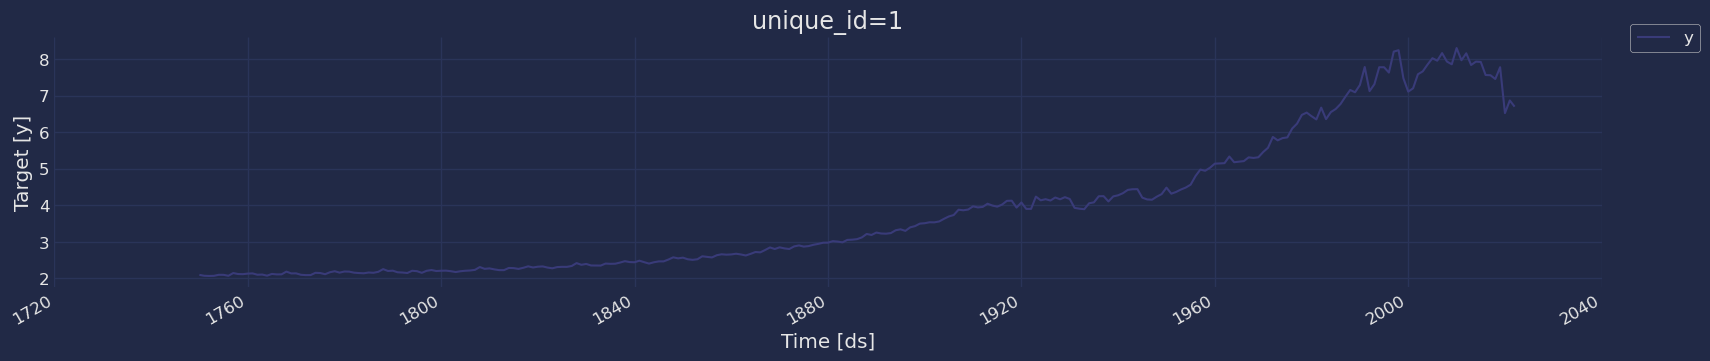

In [58]:
StatsForecast.plot(emissions, engine='matplotlib')


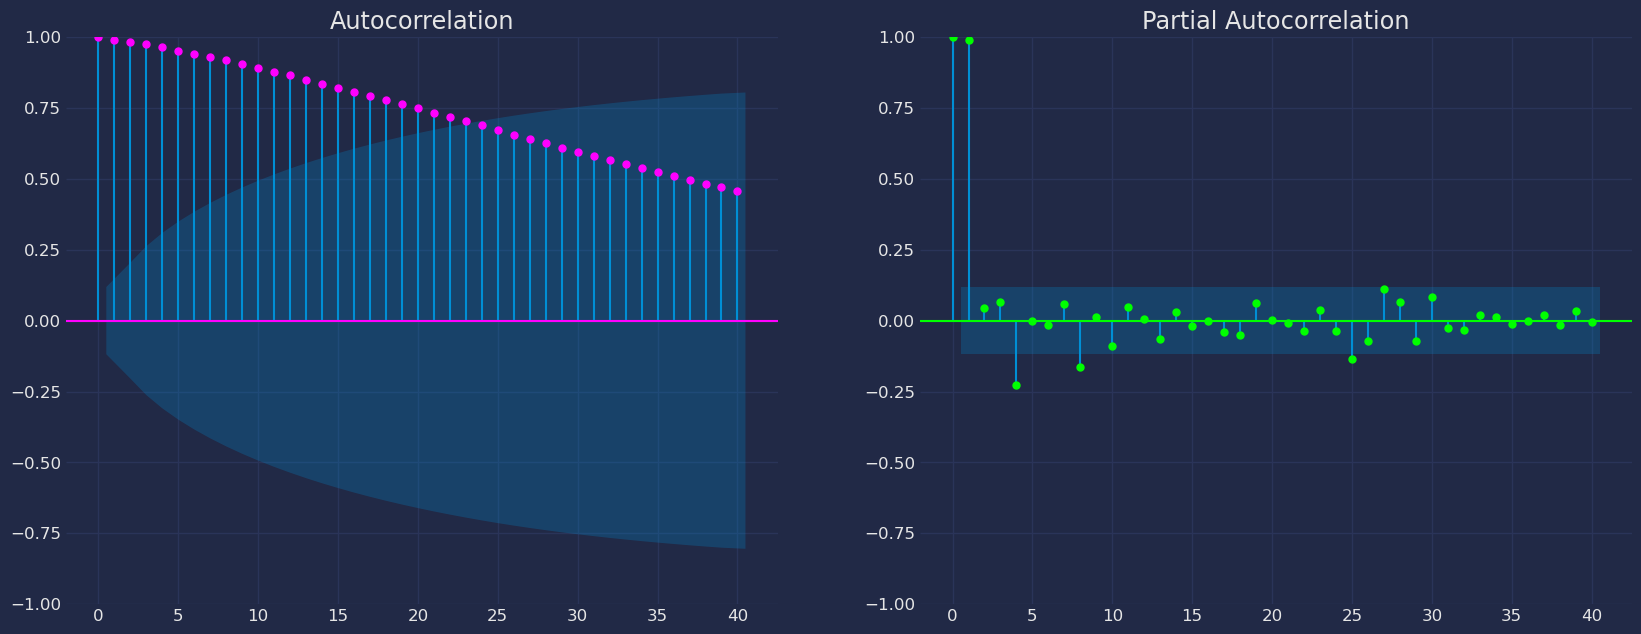

In [59]:
fig, axs = plt.subplots(nrows=1, ncols=2)

plot_acf(emissions["y"],  lags=40, ax=axs[0],color="fuchsia")
axs[0].set_title("Autocorrelation");

plot_pacf(emissions["y"],  lags=40, ax=axs[1],color="lime")
axs[1].set_title('Partial Autocorrelation')

plt.show();


In [60]:
# CO2_train = emissions[emissions.ds<='2000-01-01'] 
# CO2_test = emissions[emissions.ds>'2000-01-01']
# CO2_train.shape, CO2_test.shape

CO2_train = emissions


In [61]:
T = np.arange(1750,2023)
T_train = T
# T_train = T[T < 2001]
# T_test = T[~(T < 2001)]

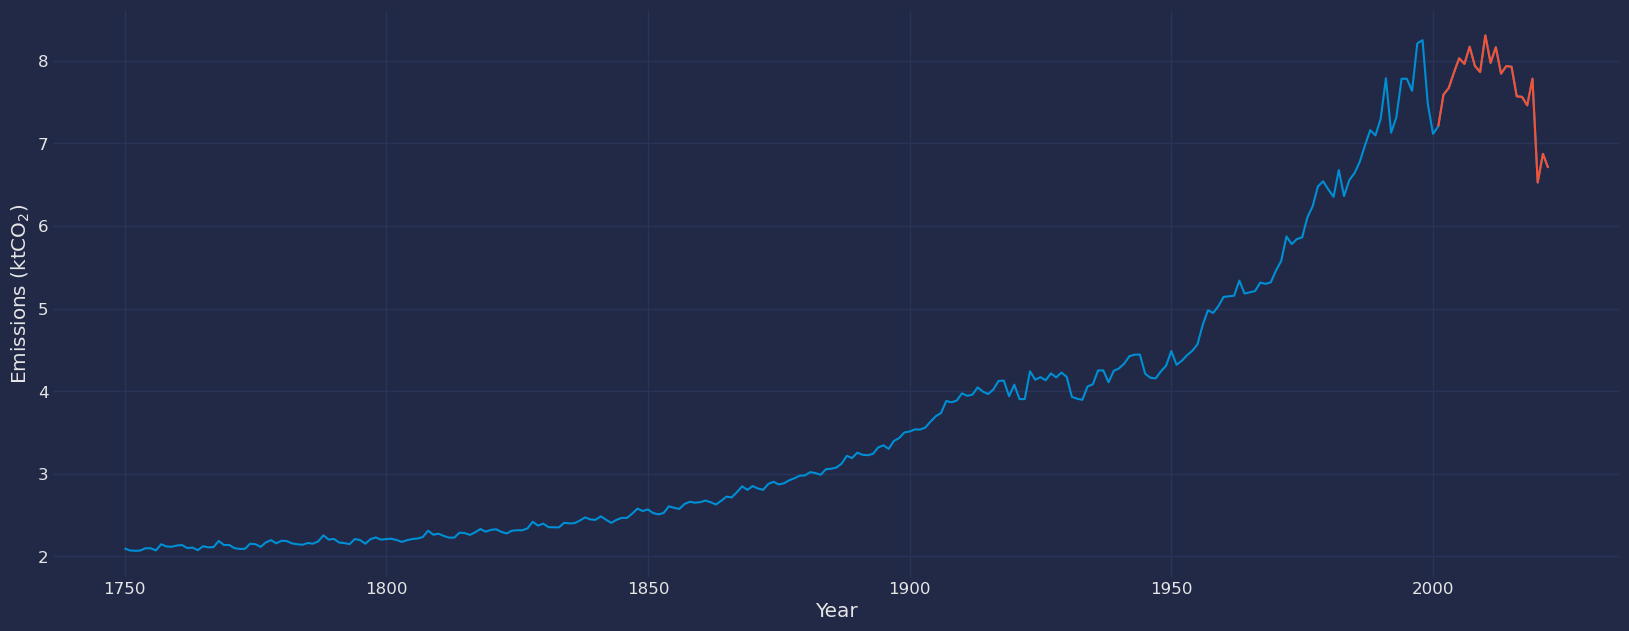

In [62]:
plt.plot(T_train,CO2_train['y'], label="Train")
plt.plot(T_test,CO2_test['y'], label="Test")
plt.xlabel('Year')
plt.ylabel(f'Emissions (ktCO$_2$)')
plt.show()


### Modeling

In [63]:
season_length = 1 # Yearly data 
horizon = len(CO2_test) # number of predictions

models = [AutoARIMA(season_length=season_length)]

sf = StatsForecast(df=CO2_train,
                   models=models,
                   freq='YS', 
                   n_jobs=-1)

/mmfs1/gscratch/amath/dob1998/miniconda3/lib/python3.12/site-packages/statsforecast/core.py:476: FutureWarning: The `df` argument of the StatsForecast constructor as well as reusing stored dfs from other methods is deprecated and will raise an error in a future version. Please provide the `df` argument to the corresponding method instead, e.g. fit/forecast.
  warnings.warn(


In [64]:
sf.fit()
StatsForecast(models=[AutoARIMA], freq='YS')

arima_string(sf.fitted_[0,0].model_)

/mmfs1/gscratch/amath/dob1998/miniconda3/lib/python3.12/site-packages/statsforecast/core.py:476: FutureWarning: The `df` argument of the StatsForecast constructor as well as reusing stored dfs from other methods is deprecated and will raise an error in a future version. Please provide the `df` argument to the corresponding method instead, e.g. fit/forecast.
  warnings.warn(


'ARIMA(1,1,2)                   '

In [65]:
result=sf.fitted_[0,0].model_

residual=pd.DataFrame(result.get("residuals"), columns=["residual Model"])
residual

,residual Model
0,0.002097
1,-0.023478
2,-0.010641
3,0.001812
4,0.030109
...,...
268,-0.130942
269,0.298301
270,-1.150997
271,0.017164


In [66]:
# plt.plot(result['x'])
print(result['xreg'])

None


In [67]:
result.keys()

dict_keys(['coef', 'sigma2', 'var_coef', 'mask', 'loglik', 'aic', 'arma', 'residuals', 'code', 'n_cond', 'nobs', 'model', 'bic', 'aicc', 'ic', 'xreg', 'x', 'lambda'])

In [68]:
result['model'].keys()

dict_keys(['phi', 'theta', 'delta', 'Z', 'a', 'P', 'T', 'V', 'h', 'Pn'])

/tmp/ipykernel_47968/312260686.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(residual, ax=axs[0,1]);


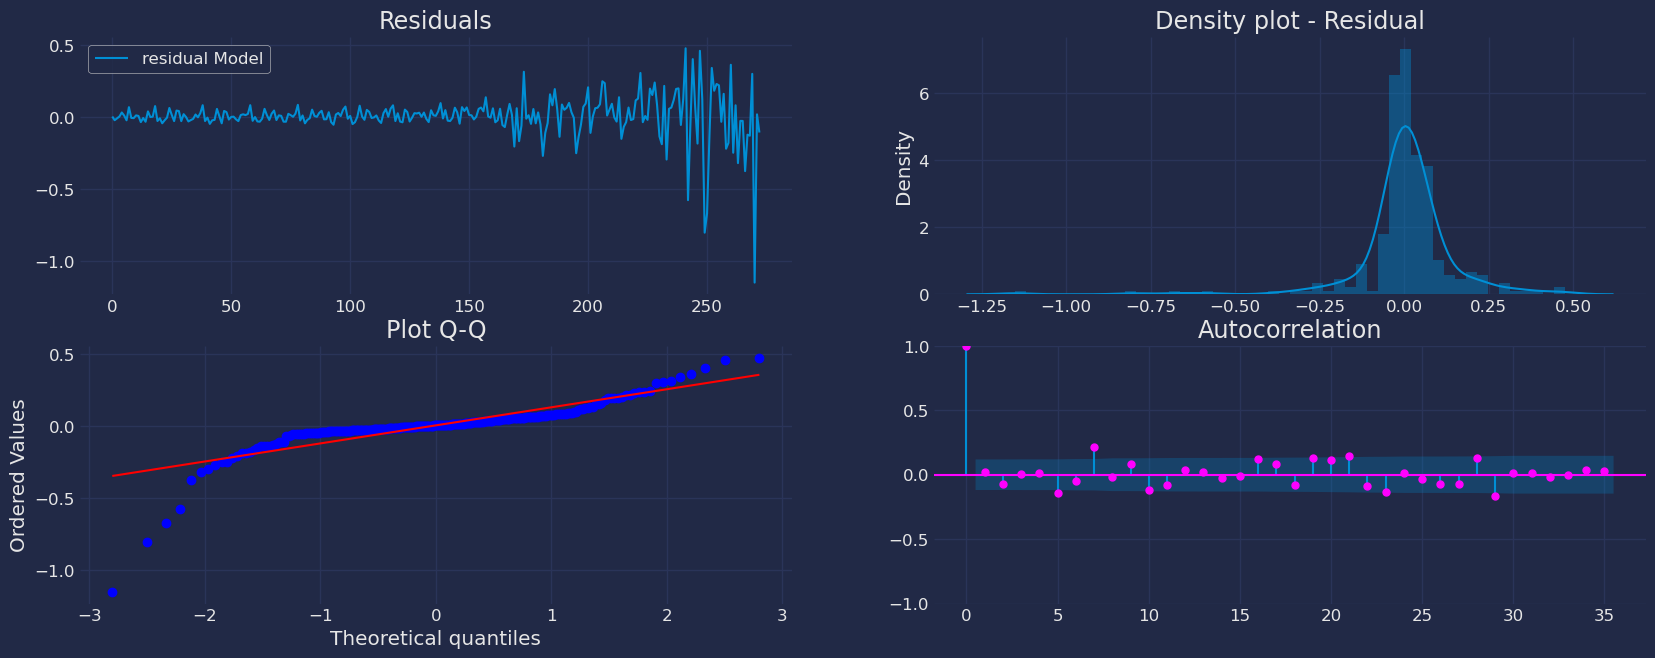

In [69]:
fig, axs = plt.subplots(nrows=2, ncols=2)

# plot[1,1]
residual.plot(ax=axs[0,0])
axs[0,0].set_title("Residuals");

# plot
sns.distplot(residual, ax=axs[0,1]);
axs[0,1].set_title("Density plot - Residual");

# plot
stats.probplot(residual["residual Model"], dist="norm", plot=axs[1,0])
axs[1,0].set_title('Plot Q-Q')

# plot
plot_acf(residual,  lags=35, ax=axs[1,1],color="fuchsia")
axs[1,1].set_title("Autocorrelation");

plt.show();


In [71]:
Y_hat_df = sf.forecast(horizon, fitted=True)
Y_hat_df.head()

values=sf.forecast_fitted_values()
values


/mmfs1/gscratch/amath/dob1998/miniconda3/lib/python3.12/site-packages/statsforecast/core.py:476: FutureWarning: The `df` argument of the StatsForecast constructor as well as reusing stored dfs from other methods is deprecated and will raise an error in a future version. Please provide the `df` argument to the corresponding method instead, e.g. fit/forecast.
  warnings.warn(
/mmfs1/gscratch/amath/dob1998/miniconda3/lib/python3.12/site-packages/statsforecast/core.py:494: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/mmfs1/gscratch/amath/dob1998/miniconda3/lib/python3.12/site-packages/statsforecast/core.py:494: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


,ds,y,AutoARIMA
unique_id,,,
1,1750-01-01,2.096766,2.094669
1,1751-01-01,2.071972,2.095449
1,1752-01-01,2.067178,2.077820
1,1753-01-01,2.070382,2.068570
1,1754-01-01,2.098586,2.068477
...,...,...,...
1,2018-01-01,7.459095,7.590037
1,2019-01-01,7.781842,7.483541
1,2020-01-01,6.525021,7.676017


In [72]:
sf.forecast(h=22, level=[95])


/mmfs1/gscratch/amath/dob1998/miniconda3/lib/python3.12/site-packages/statsforecast/core.py:476: FutureWarning: The `df` argument of the StatsForecast constructor as well as reusing stored dfs from other methods is deprecated and will raise an error in a future version. Please provide the `df` argument to the corresponding method instead, e.g. fit/forecast.
  warnings.warn(
/mmfs1/gscratch/amath/dob1998/miniconda3/lib/python3.12/site-packages/statsforecast/core.py:494: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


,ds,AutoARIMA,AutoARIMA-lo-95,AutoARIMA-hi-95
unique_id,,,,
1,2023-01-01,6.679771,6.389650,6.969892
1,2024-01-01,6.623046,6.267394,6.978698
1,2025-01-01,6.568195,6.150707,6.985684
1,2026-01-01,6.515158,6.037945,6.992371
1,2027-01-01,6.463875,5.928238,6.999511
1,2028-01-01,6.414287,5.821069,7.007505
1,2029-01-01,6.366338,5.716105,7.016572
1,2030-01-01,6.319975,5.613121,7.026830
1,2031-01-01,6.275145,5.511956,7.038333


In [73]:
Y_hat_df=Y_hat_df.reset_index()
Y_hat_df


,unique_id,ds,AutoARIMA
0,1,2023-01-01,6.679771
1,1,2024-01-01,6.623046
2,1,2025-01-01,6.568195
3,1,2026-01-01,6.515158
4,1,2027-01-01,6.463875
5,1,2028-01-01,6.414287
6,1,2029-01-01,6.366338
7,1,2030-01-01,6.319975
8,1,2031-01-01,6.275145
9,1,2032-01-01,6.231797


In [48]:
CO2_test['unique_id'] = CO2_test['unique_id'].astype(int)
# CO2_test['unique_id'] = CO2_test['unique_id'].astype(int)
Y_hat_df['unique_id'] = Y_hat_df['unique_id'].astype(int)
CO2_test['ds'] = pd.to_datetime(CO2_test['ds'])
Y_hat_df = CO2_test.merge(Y_hat_df, how='left', on=['unique_id', 'ds'])

/tmp/ipykernel_47968/3673727429.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CO2_test['unique_id'] = CO2_test['unique_id'].astype(int)
/tmp/ipykernel_47968/3673727429.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CO2_test['ds'] = pd.to_datetime(CO2_test['ds'])


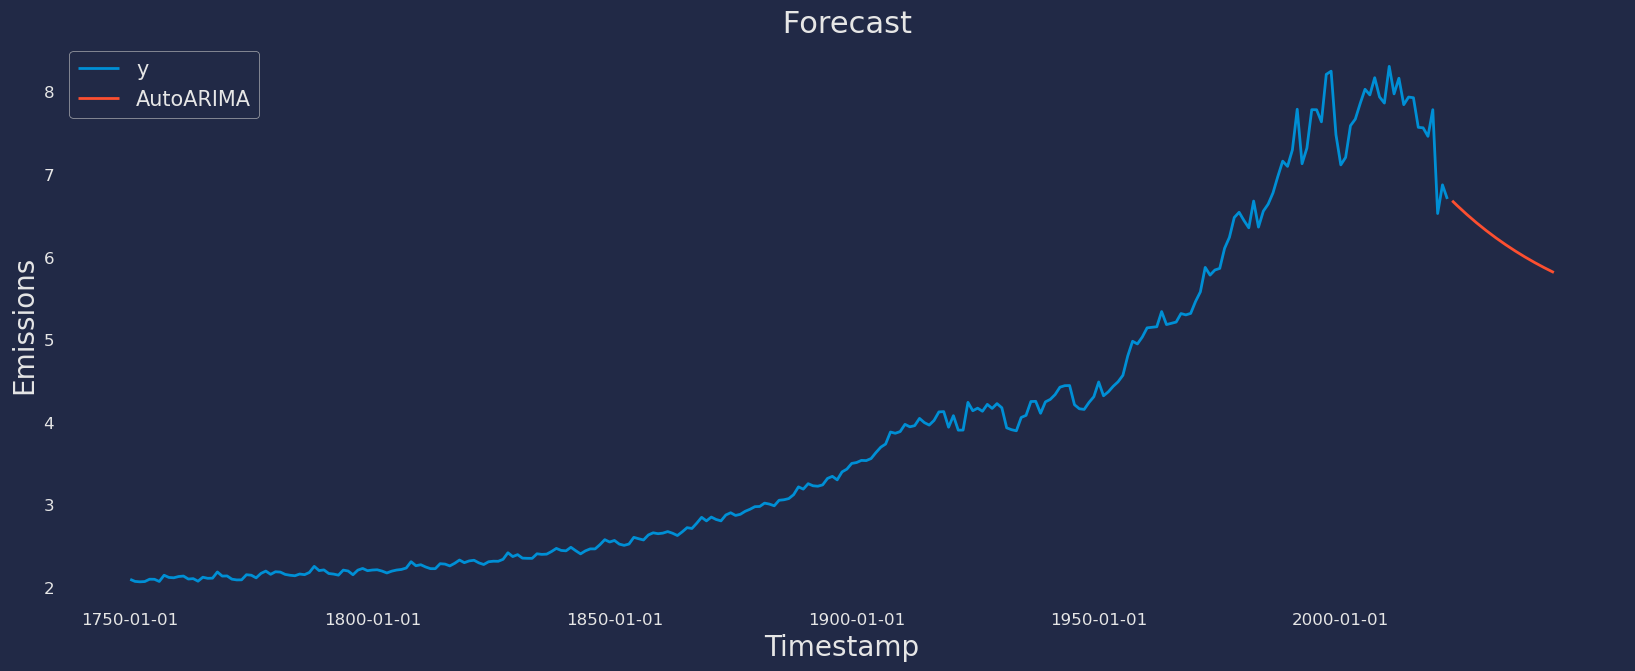

In [74]:
fig, ax = plt.subplots(1, 1, figsize = (18, 7))
plot_df = pd.concat([CO2_train, Y_hat_df]).set_index('ds')
plot_df[['y', 'AutoARIMA']].plot(ax=ax, linewidth=2)
ax.set_title(' Forecast', fontsize=22)
ax.set_ylabel('Emissions', fontsize=20)
ax.set_xlabel('Timestamp', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()


### The ACF and PACF do not indicate that there is much left about the trend to explain

Text(0.5, 1.0, 'Partial Autocorrelation')

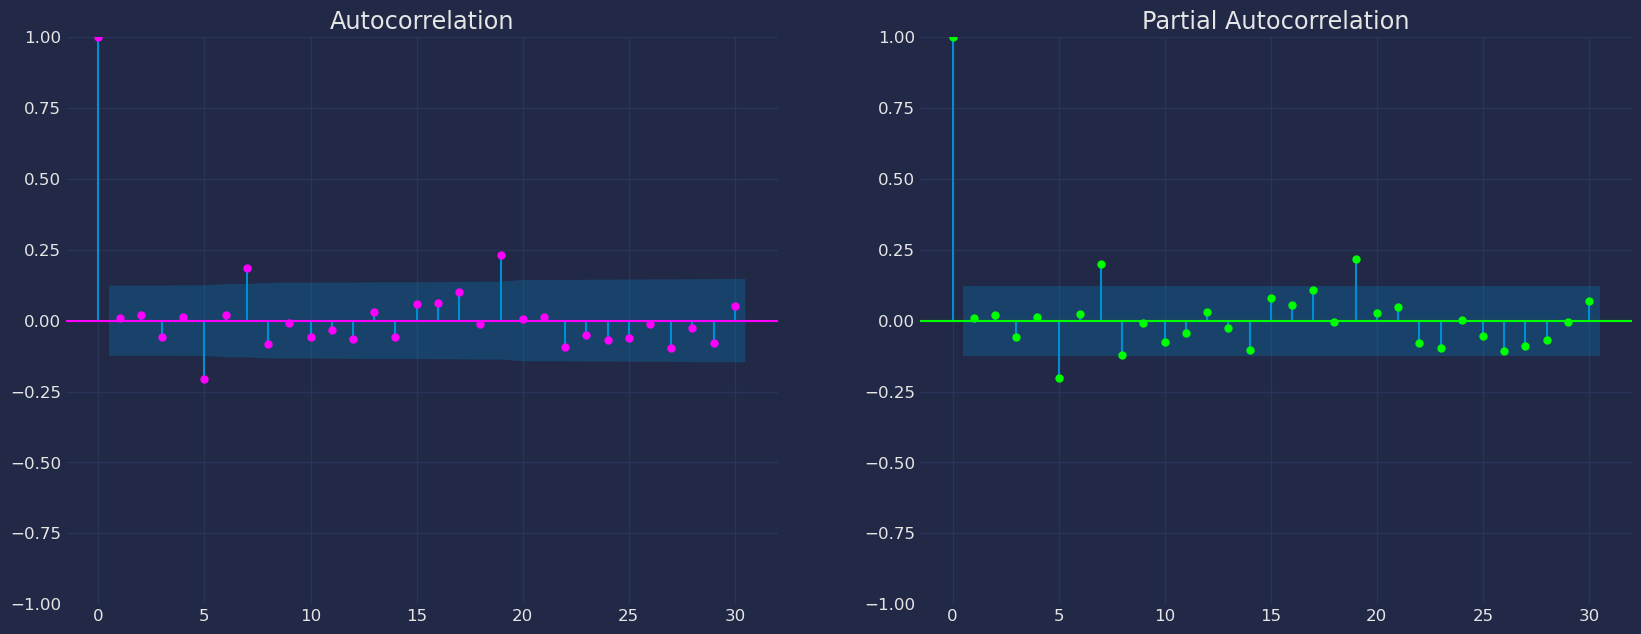

In [50]:
fig, axs = plt.subplots(nrows=1, ncols=2)
plot_acf(residual,  lags=30, ax=axs[0],color="fuchsia")
axs[0].set_title("Autocorrelation");

plot_pacf(residual,  lags=30, ax=axs[1],color="lime")
axs[1].set_title('Partial Autocorrelation')

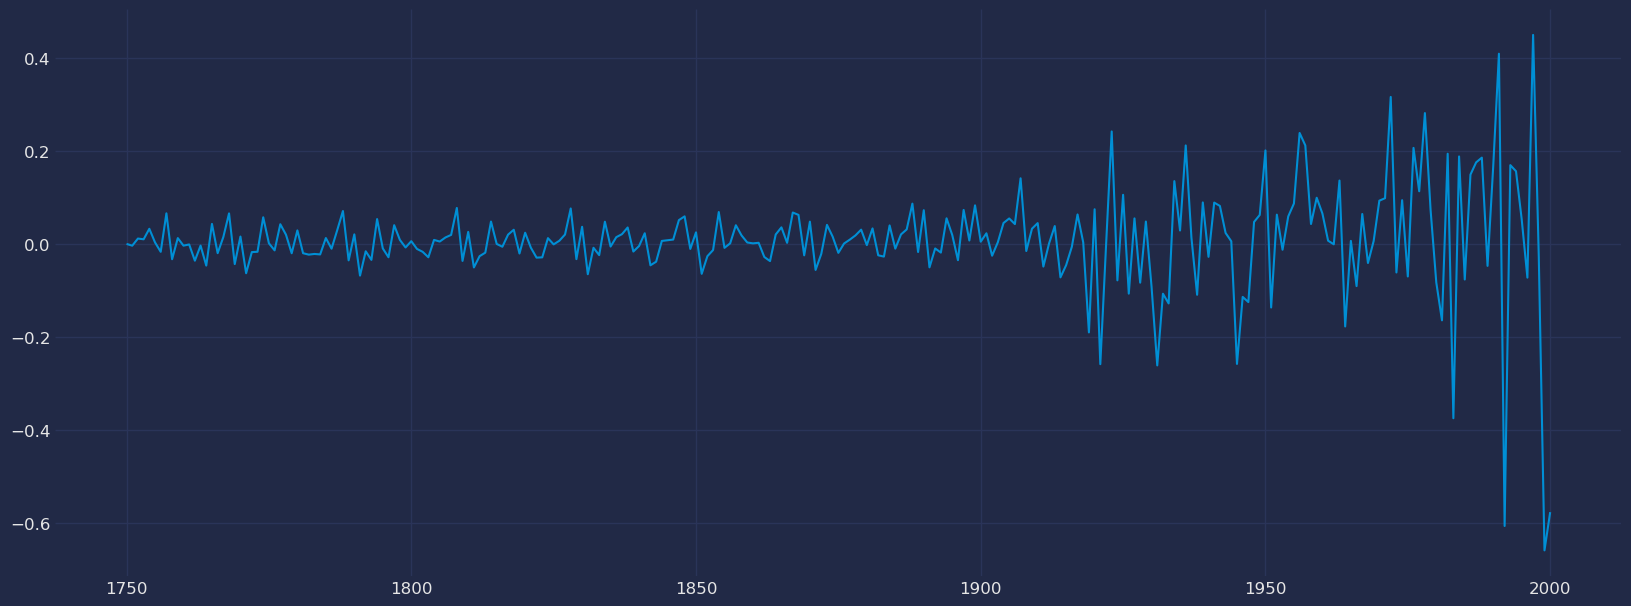

In [51]:
plt.plot(T_train,residual)

### Looking to see if the double differenced series is stationary

Text(0.5, 1.0, 'Partial Autocorrelation')

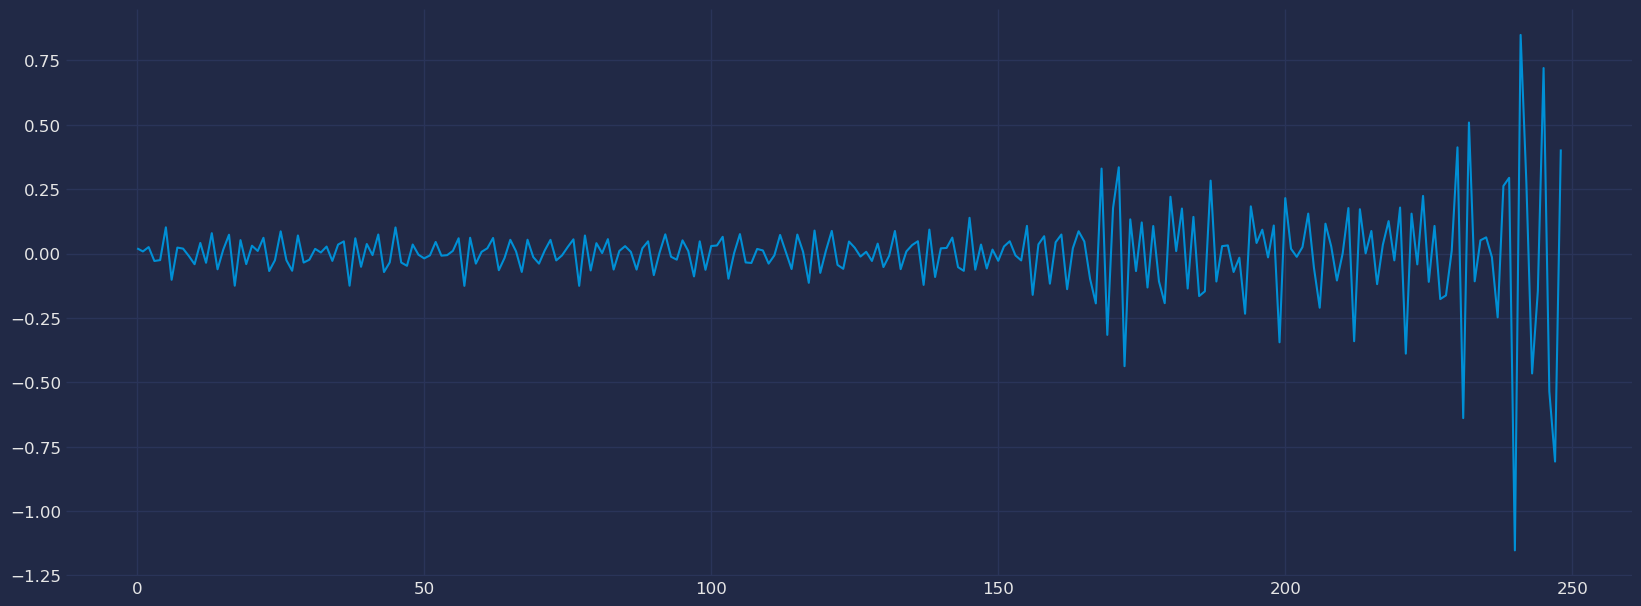

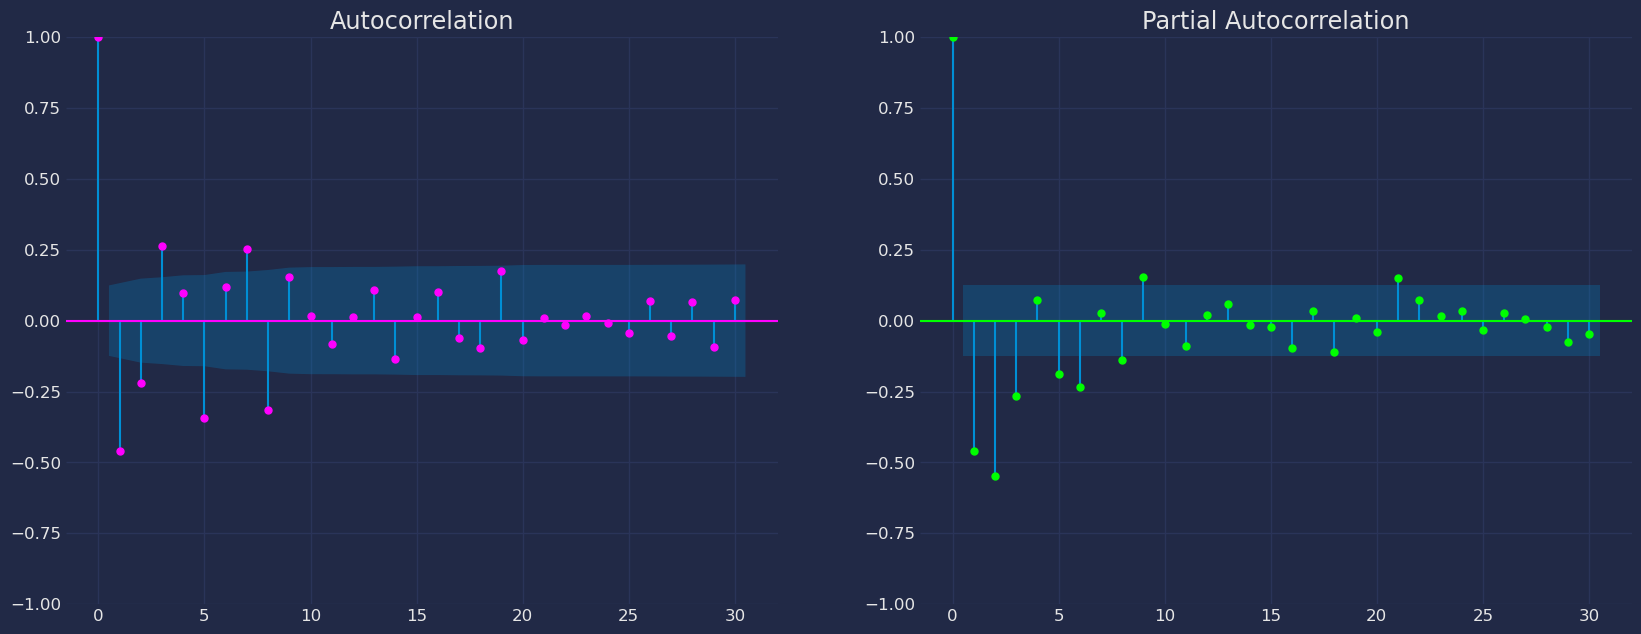

In [52]:
CO2_train_values = CO2_train['y'].values
temp1 = CO2_train_values[1:] - CO2_train_values[:-1]
temp2 = temp1[1:] - temp1[:-1]
plt.plot(temp2)

fig, axs = plt.subplots(nrows=1, ncols=2)
plot_acf(temp2,  lags=30, ax=axs[0],color="fuchsia")
axs[0].set_title("Autocorrelation");
plot_pacf(temp2,  lags=30, ax=axs[1],color="lime")
axs[1].set_title('Partial Autocorrelation')

## Forecasting with autoARIMA: https://nixtlaverse.nixtla.io/statsforecast/docs/models/autoarima.html

### Loading Libraries and Data

In [37]:
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
dark_style = {
    'figure.facecolor': '#212946',
    'axes.facecolor': '#212946',
    'savefig.facecolor':'#212946',
    'axes.grid': True,
    'axes.grid.which': 'both',
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False,
    'grid.color': '#2A3459',
    'grid.linewidth': '1',
    'text.color': '0.9',
    'axes.labelcolor': '0.9',
    'xtick.color': '0.9',
    'ytick.color': '0.9',
    'font.size': 12 }
plt.rcParams.update(dark_style)

from pylab import rcParams
rcParams['figure.figsize'] = (18,7)


In [38]:
df = pd.read_csv('https://raw.githubusercontent.com/Naren8520/Serie-de-tiempo-con-Machine-Learning/main/Data/candy_production.csv')
df.head()


,observation_date,IPG3113N
0,1972-01-01,85.6945
1,1972-02-01,71.8200
2,1972-03-01,66.0229
3,1972-04-01,64.5645
4,1972-05-01,65.0100


In [39]:
df['unique_id']=1
df.columns=['ds', 'y', 'unique_id']
df.head()


,ds,y,unique_id
0,1972-01-01,85.6945,1
1,1972-02-01,71.8200,1
2,1972-03-01,66.0229,1
3,1972-04-01,64.5645,1
4,1972-05-01,65.0100,1


In [40]:
print(df.dtypes)


ds            object
y            float64
unique_id      int64
dtype: object


### Explore Data with the Plot Method 

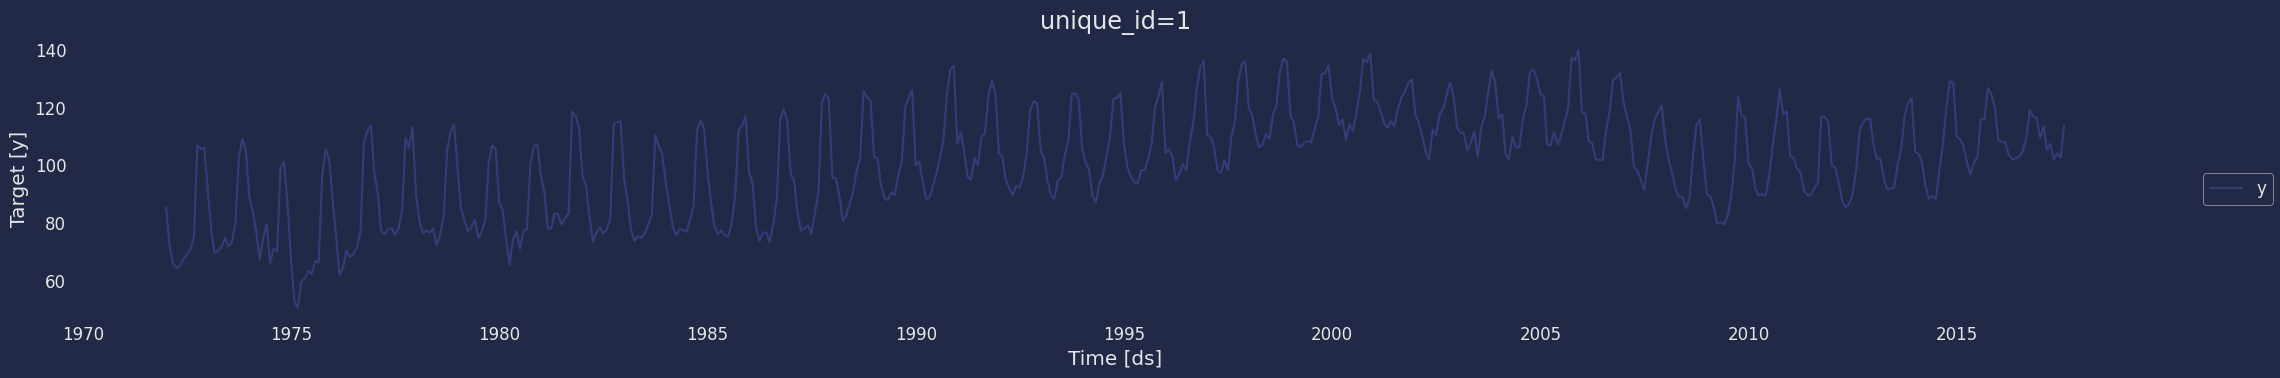

In [41]:
StatsForecast.plot(df, engine='matplotlib')


### Split the Data into Training and Testing

In [42]:
Y_train_df = df[df.ds<='2016-08-01'] 
Y_test_df = df[df.ds>'2016-08-01']


In [43]:
Y_train_df.shape, Y_test_df.shape


((536, 3), (12, 3))

In [44]:
print(df.dtypes)


ds            object
y            float64
unique_id      int64
dtype: object


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


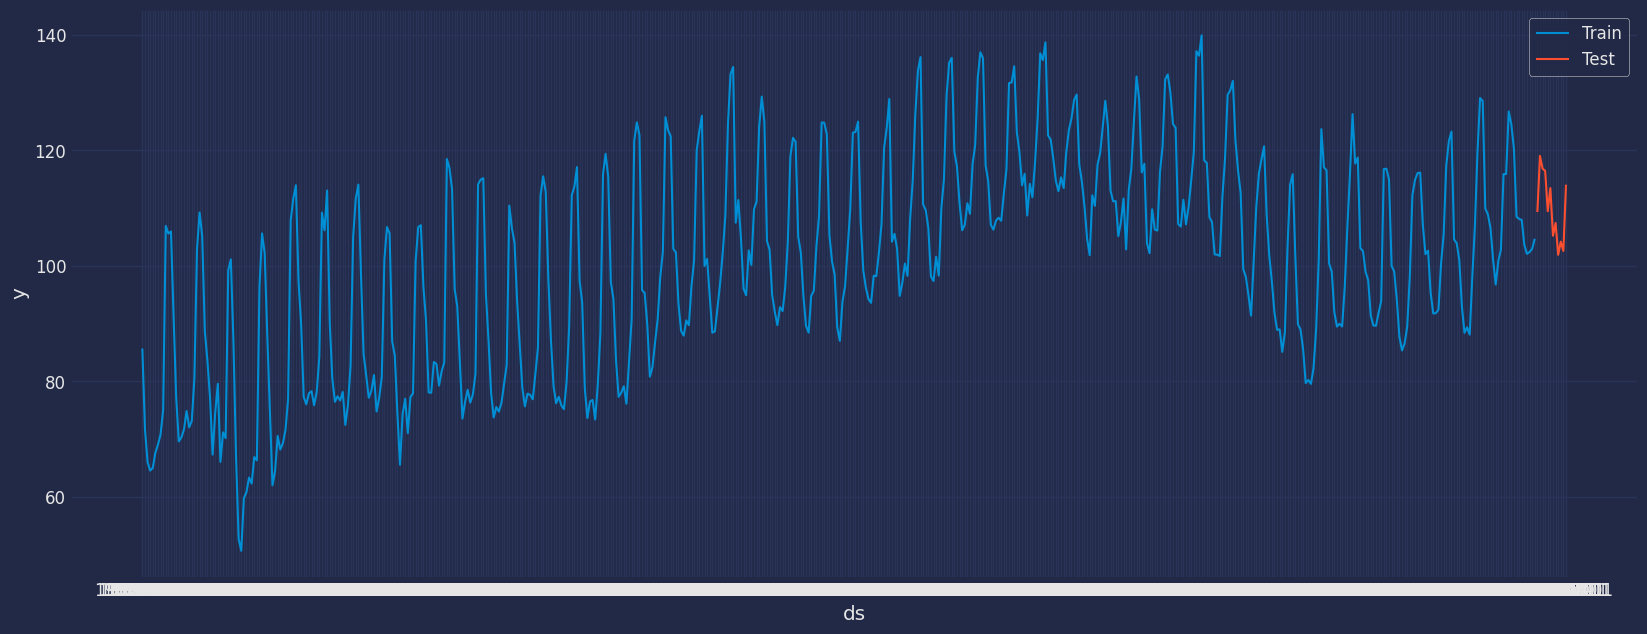

In [45]:
sns.lineplot(Y_train_df,x="ds", y="y", label="Train")
sns.lineplot(Y_test_df, x="ds", y="y", label="Test")
plt.show()


### Implementation of Statsforecasting with autoARIMA


In [46]:
season_length = 12 # Monthly data 
horizon = len(Y_test_df) # number of predictions

models = [AutoARIMA(season_length=season_length)]


In [47]:
sf = StatsForecast(df=Y_train_df,
                   models=models,
                   freq='MS', 
                   n_jobs=-1)


c:\Users\damie\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsforecast\core.py:467: FutureWarning: The `df` argument of the StatsForecast constructor as well as reusing stored dfs from other methods is deprecated and will raise an error in a future version. Please provide the `df` argument to the corresponding method instead, e.g. fit/forecast.
  warnings.warn(


### Fit the Model

In [48]:
sf.fit()


c:\Users\damie\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsforecast\core.py:467: FutureWarning: The `df` argument of the StatsForecast constructor as well as reusing stored dfs from other methods is deprecated and will raise an error in a future version. Please provide the `df` argument to the corresponding method instead, e.g. fit/forecast.
  warnings.warn(


KeyboardInterrupt: 

Exception ignored in: 'zmq.backend.cython.message.Frame.__dealloc__'
Traceback (most recent call last):
  File "zmq\\backend\\cython\\checkrc.pxd", line 13, in zmq.backend.cython.checkrc._check_rc
KeyboardInterrupt: 


StatsForecast(models=[AutoARIMA])

In [ ]:
print(df.dtypes)


ds            object
y            float64
unique_id      int64
dtype: object


In [ ]:
StatsForecast(models=[AutoARIMA], freq='MS')


StatsForecast(models=[<class 'statsforecast.models.AutoARIMA'>])

In [ ]:
arima_string(sf.fitted_[0,0].model_)


'ARIMA(1,0,0)(0,1,2)[12]                   '

In [ ]:
result=sf.fitted_[0,0].model_
print(result.keys())
print(result['arma'])


dict_keys(['coef', 'sigma2', 'var_coef', 'mask', 'loglik', 'aic', 'arma', 'residuals', 'code', 'n_cond', 'nobs', 'model', 'bic', 'aicc', 'ic', 'xreg', 'x', 'lambda'])
(1, 0, 0, 2, 12, 0, 1)


In [ ]:
residual=pd.DataFrame(result.get("residuals"), columns=["residual Model"])
residual


,residual Model
0,0.085694
1,0.071820
2,0.066023
3,0.064564
4,0.065010
...,...
531,3.008596
532,3.942651
533,1.258874
534,1.585062


C:\Users\damie\AppData\Local\Temp\ipykernel_14956\312260686.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(residual, ax=axs[0,1]);


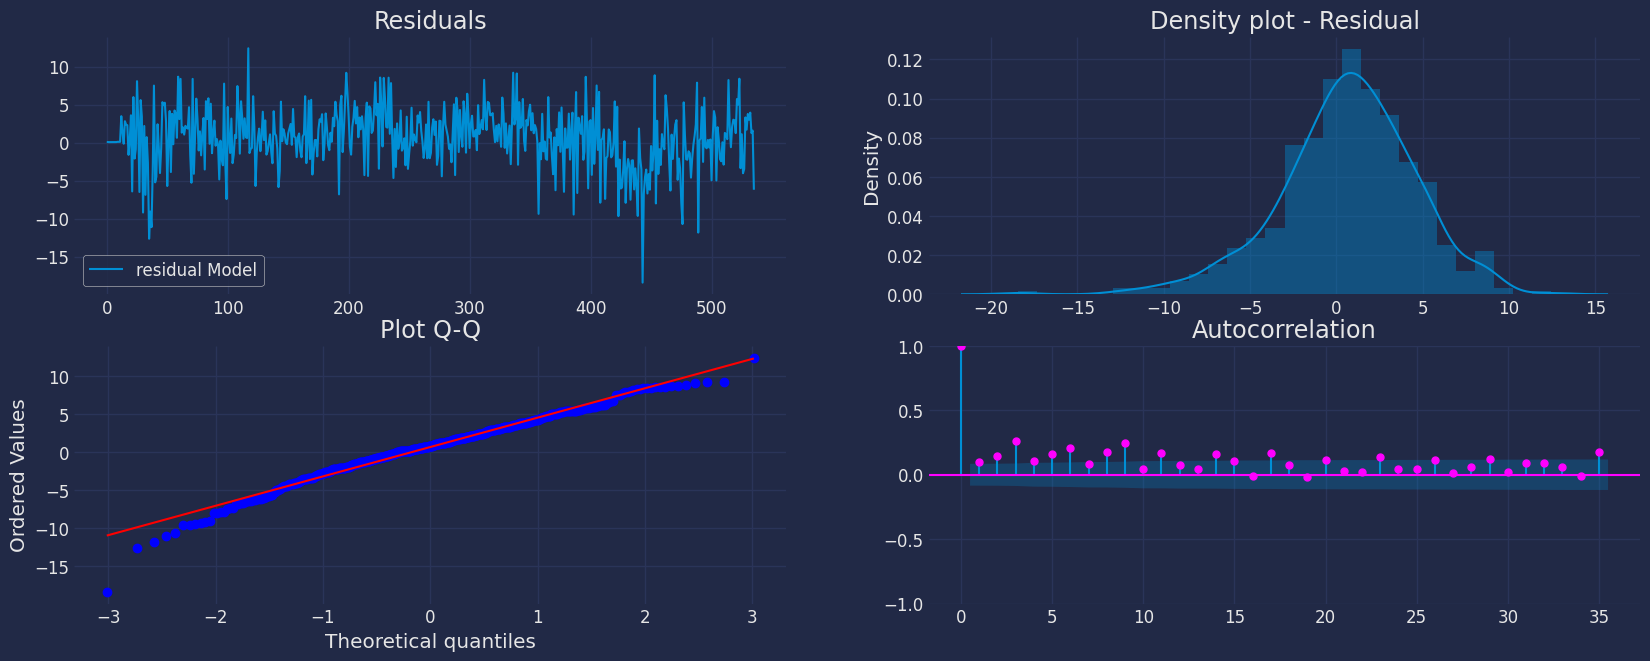

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2)

# plot[1,1]
residual.plot(ax=axs[0,0])
axs[0,0].set_title("Residuals");

# plot
sns.distplot(residual, ax=axs[0,1]);
axs[0,1].set_title("Density plot - Residual");

# plot
stats.probplot(residual["residual Model"], dist="norm", plot=axs[1,0])
axs[1,0].set_title('Plot Q-Q')

# plot
plot_acf(residual,  lags=35, ax=axs[1,1],color="fuchsia")
axs[1,1].set_title("Autocorrelation");

plt.show();


### Forecast Method

In [ ]:
Y_hat_df = sf.forecast(horizon, fitted=True)

Y_hat_df.head()


c:\Users\damie\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsforecast\core.py:467: FutureWarning: The `df` argument of the StatsForecast constructor as well as reusing stored dfs from other methods is deprecated and will raise an error in a future version. Please provide the `df` argument to the corresponding method instead, e.g. fit/forecast.
  warnings.warn(
c:\Users\damie\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsforecast\core.py:485: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


,ds,AutoARIMA
unique_id,,
1,2016-09-01,109.955437
1,2016-10-01,121.920509
1,2016-11-01,122.458389
1,2016-12-01,120.562027
1,2017-01-01,106.864670


In [ ]:
print(Y_hat_df.dtypes)

ds           datetime64[ns]
AutoARIMA           float32
dtype: object


In [ ]:
values=sf.forecast_fitted_values()
values

c:\Users\damie\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsforecast\core.py:485: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


,ds,y,AutoARIMA
unique_id,,,
1,1972-01-01,85.694504,85.608803
1,1972-02-01,71.820000,71.748177
1,1972-03-01,66.022903,65.956879
1,1972-04-01,64.564499,64.499939
1,1972-05-01,65.010002,64.944992
...,...,...,...
1,2016-04-01,103.617897,100.609306
1,2016-05-01,102.081596,98.138947
1,2016-06-01,102.404404,101.145523


In [ ]:
sf.forecast(h=12, level=[95])


c:\Users\damie\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsforecast\core.py:467: FutureWarning: The `df` argument of the StatsForecast constructor as well as reusing stored dfs from other methods is deprecated and will raise an error in a future version. Please provide the `df` argument to the corresponding method instead, e.g. fit/forecast.
  warnings.warn(
c:\Users\damie\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsforecast\core.py:485: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


,ds,AutoARIMA,AutoARIMA-lo-95,AutoARIMA-hi-95
unique_id,,,,
1,2016-09-01,109.955437,102.123718,117.787163
1,2016-10-01,121.920509,112.389771,131.451248
1,2016-11-01,122.458389,112.210350,132.706436
1,2016-12-01,120.562027,109.986313,131.137741
1,2017-01-01,106.864670,96.134926,117.594414
1,2017-02-01,105.721741,94.918701,116.524780
1,2017-03-01,103.670792,92.832672,114.508904
1,2017-04-01,98.512344,87.657394,109.367287
1,2017-05-01,96.068993,85.205963,106.932022


In [ ]:
Y_hat_df=Y_hat_df.reset_index()
Y_hat_df


,unique_id,ds,AutoARIMA
0,1,2016-09-01,109.955437
1,1,2016-10-01,121.920509
2,1,2016-11-01,122.458389
3,1,2016-12-01,120.562027
4,1,2017-01-01,106.864670
5,1,2017-02-01,105.721741
6,1,2017-03-01,103.670792
7,1,2017-04-01,98.512344
8,1,2017-05-01,96.068993
9,1,2017-06-01,96.751160


C:\Users\damie\AppData\Local\Temp\ipykernel_14956\1795384921.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_test_df['unique_id'] = Y_test_df['unique_id'].astype(int)
C:\Users\damie\AppData\Local\Temp\ipykernel_14956\1795384921.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_test_df['ds'] = pd.to_datetime(Y_test_df['ds'])


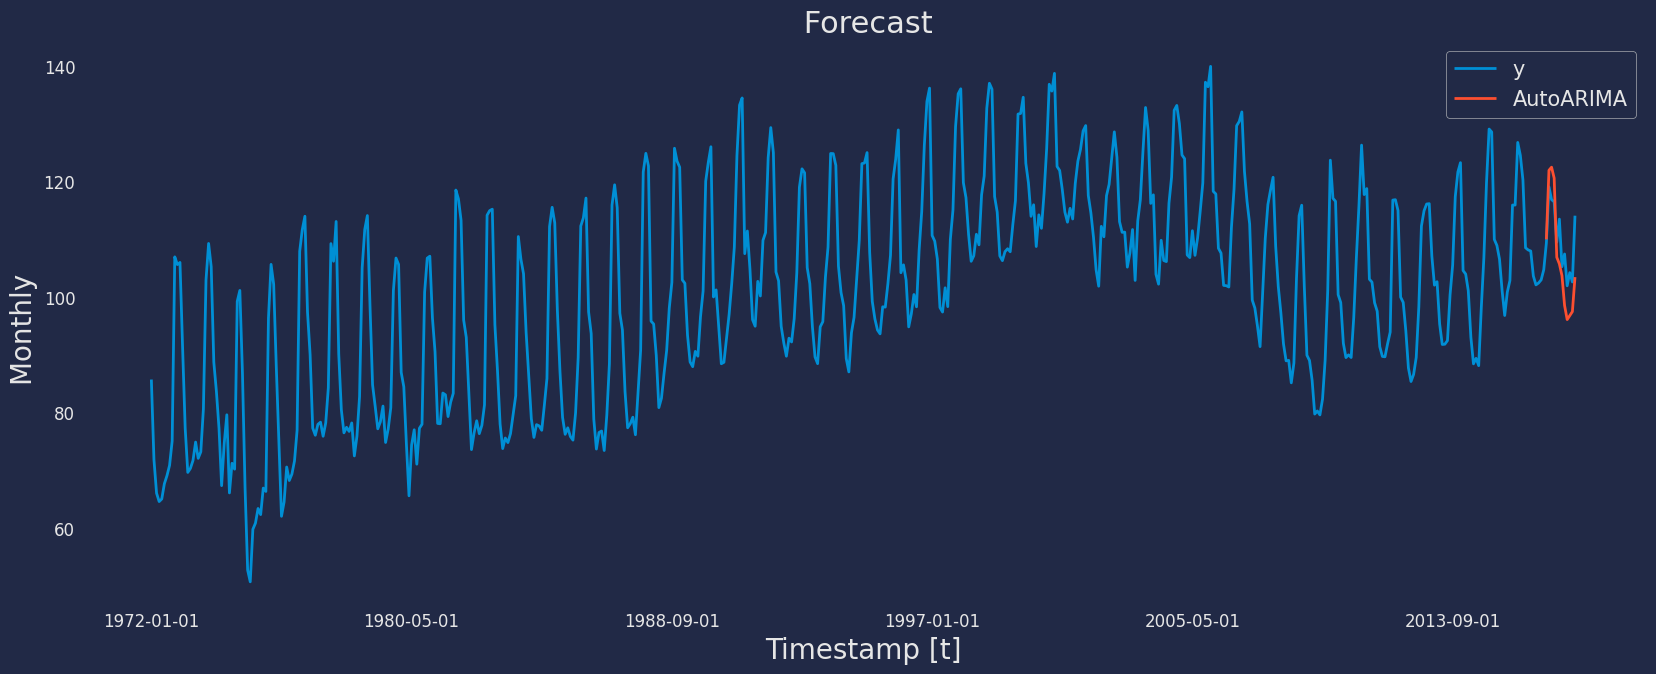

In [ ]:
Y_test_df['unique_id'] = Y_test_df['unique_id'].astype(int)
# Y_test_df['unique_id'] = Y_test_df['unique_id'].astype(int)
# Y_hat_df['unique_id'] = Y_hat_df['unique_id'].astype(int)
Y_test_df['ds'] = pd.to_datetime(Y_test_df['ds'])
Y_hat_df = Y_test_df.merge(Y_hat_df, how='left', on=['unique_id', 'ds'])

fig, ax = plt.subplots(1, 1, figsize = (18, 7))
plot_df = pd.concat([Y_train_df, Y_hat_df]).set_index('ds')
plot_df[['y', 'AutoARIMA']].plot(ax=ax, linewidth=2)
ax.set_title(' Forecast', fontsize=22)
ax.set_ylabel('Monthly ', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()


### Predict Method With Confidence Interval

In [ ]:
sf.predict(h=12)


c:\Users\damie\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsforecast\core.py:485: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


,ds,AutoARIMA
unique_id,,
1,2016-09-01,109.955437
1,2016-10-01,121.920509
1,2016-11-01,122.458389
1,2016-12-01,120.562027
1,2017-01-01,106.864670
1,2017-02-01,105.721741
1,2017-03-01,103.670792
1,2017-04-01,98.512344
1,2017-05-01,96.068993


In [ ]:
forecast_df = sf.predict(h=12, level = [80, 95]) 

forecast_df

c:\Users\damie\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsforecast\core.py:485: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


,ds,AutoARIMA,AutoARIMA-lo-95,AutoARIMA-lo-80,AutoARIMA-hi-80,AutoARIMA-hi-95
unique_id,,,,,,
1,2016-09-01,109.955437,102.123718,104.834549,115.076324,117.787163
1,2016-10-01,121.920509,112.389771,115.688690,128.152328,131.451248
1,2016-11-01,122.458389,112.210350,115.757553,129.159225,132.706436
1,2016-12-01,120.562027,109.986313,113.646942,127.477112,131.137741
1,2017-01-01,106.864670,96.134926,99.848869,113.880478,117.594414
1,2017-02-01,105.721741,94.918701,98.658012,112.785469,116.524780
1,2017-03-01,103.670792,92.832672,96.584129,110.757454,114.508904
1,2017-04-01,98.512344,87.657394,91.414673,105.610008,109.367287
1,2017-05-01,96.068993,85.205963,88.966042,103.171944,106.932022


In [ ]:
df_plot=pd.concat([df, forecast_df]).set_index('ds').tail(220)
df_plot


,y,unique_id,AutoARIMA,AutoARIMA-lo-95,AutoARIMA-lo-80,AutoARIMA-hi-80,AutoARIMA-hi-95
ds,,,,,,,
2000-05-01,108.7202,1.0,NaN,NaN,NaN,NaN,NaN
2000-06-01,114.2071,1.0,NaN,NaN,NaN,NaN,NaN
2000-07-01,111.8737,1.0,NaN,NaN,NaN,NaN,NaN
2000-08-01,117.9027,1.0,NaN,NaN,NaN,NaN,NaN
2000-09-01,125.6499,1.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2017-04-01 00:00:00,NaN,NaN,98.512344,87.657394,91.414673,105.610008,109.367287
2017-05-01 00:00:00,NaN,NaN,96.068993,85.205963,88.966042,103.171944,106.932022
2017-06-01 00:00:00,NaN,NaN,96.751160,85.884247,89.645668,103.856659,107.618080


C:\Users\damie\AppData\Local\Temp\ipykernel_14956\3339224907.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(temp,df_plot['AutoARIMA'], 'b-',  color="red", linewidth=2, label="AutoArima")


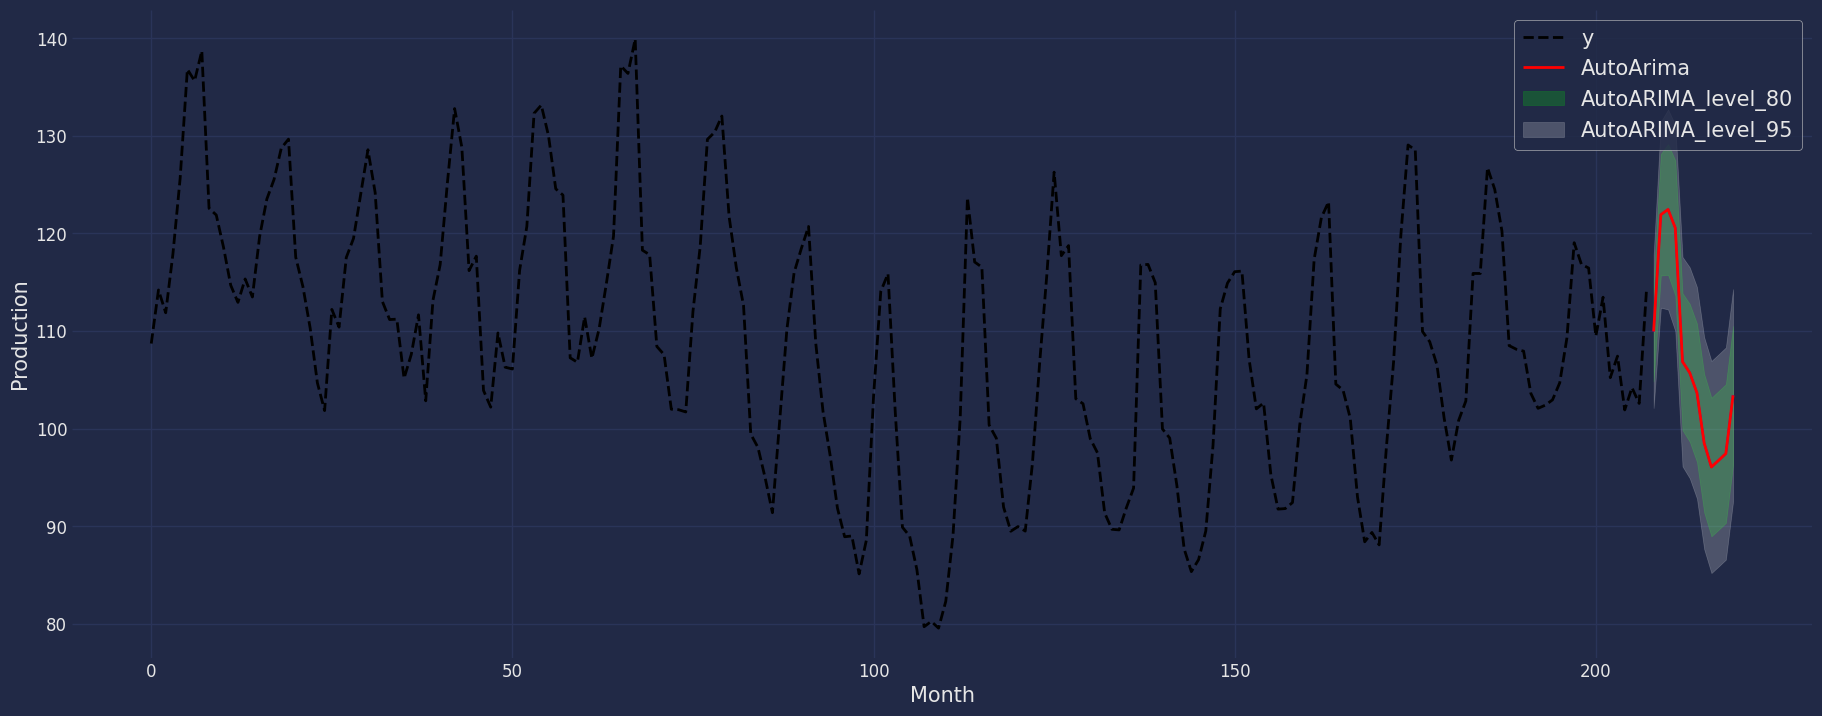

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (20, 8))
temp = np.arange(220)
# plt.plot(temp,df_plot['y'], 'k--',df_plot['AutoARIMA'], 'b-', linewidth=2 ,label="y")
plt.plot(temp,df_plot['y'], 'k--', linewidth=2 ,label="y")
plt.plot(temp,df_plot['AutoARIMA'], 'b-')
# plt.plot(temp,df_plot['AutoARIMA'], 'b-',  color="red", linewidth=2, label="AutoArima")

# Specify graph features:
# ax.fill_between(df_plot.index, 
#                 df_plot['AutoARIMA-lo-80'],
#                 df_plot['AutoARIMA-hi-80'],
#                 alpha=.20,
#                 color='lime',
#                 label='AutoARIMA_level_80')
# ax.fill_between(df_plot.index, 
#                 df_plot['AutoARIMA-lo-95'], 
#                 df_plot['AutoARIMA-hi-95'],
#                 alpha=.2,
#                 color='white',
#                 label='AutoARIMA_level_95')
ax.fill_between(temp, 
                df_plot['AutoARIMA-lo-80'],
                df_plot['AutoARIMA-hi-80'],
                alpha=.20,
                color='lime',
                label='AutoARIMA_level_80')
ax.fill_between(temp, 
                df_plot['AutoARIMA-lo-95'], 
                df_plot['AutoARIMA-hi-95'],
                alpha=.2,
                color='white',
                label='AutoARIMA_level_95')
ax.set_title('', fontsize=20)
ax.set_ylabel('Production', fontsize=15)
ax.set_xlabel('Month', fontsize=15)
ax.legend(prop={'size': 15})
ax.grid(True)
plt.show()


In [ ]:
type(df_plot.index[1])


str

In [ ]:
df_plot

,y,unique_id,AutoARIMA,AutoARIMA-lo-95,AutoARIMA-lo-80,AutoARIMA-hi-80,AutoARIMA-hi-95
ds,,,,,,,
2000-05-01,108.7202,1.0,NaN,NaN,NaN,NaN,NaN
2000-06-01,114.2071,1.0,NaN,NaN,NaN,NaN,NaN
2000-07-01,111.8737,1.0,NaN,NaN,NaN,NaN,NaN
2000-08-01,117.9027,1.0,NaN,NaN,NaN,NaN,NaN
2000-09-01,125.6499,1.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2017-04-01 00:00:00,NaN,NaN,98.512344,87.657394,91.414673,105.610008,109.367287
2017-05-01 00:00:00,NaN,NaN,96.068993,85.205963,88.966042,103.171944,106.932022
2017-06-01 00:00:00,NaN,NaN,96.751160,85.884247,89.645668,103.856659,107.618080
